<a href="https://colab.research.google.com/github/KennyNg-19/colab_nb/blob/main/CS4243.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS4243
## Image Classification

### Three classes: normal, carrying, threat


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# # %cd /content/drive/My Drive/Colab Notebooks/cs4243_smallest # Kenny Path
# %cd /content/drive/My Drive/cs4243_smallest 
# # QINI path

# !ls

## Choose: Baseline LeNet5 or Improved LeNet5 and Train/Test Model

In [3]:
'''
Use baseline Baseline LeNet5 or Improved LeNet5
'''
use_improved_model = True

# if Re-train model or load weights to Test only
train_mode = False

### Import Library

In [4]:
import os
from PIL import Image
import cv2

import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

import random
from tqdm import tqdm


def seed_torch(seed=3):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch()

In [5]:
# gpu setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


### Helper Functions

In [6]:
# Class to save the best model while training - "best_model"
class SaveBestModel:
    def __init__(
        self, save_path = "outputs", best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        self.save_path = save_path
        # create weights store file
        if not os.path.exists(save_path):
            !mkdir $save_path
            print(f"create {save_path}/ dir")
            
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{self.save_path}/best_model.pth')
            
def save_model(epochs, model, optimizer, criterion, save_path='outputs'):
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{save_path}/final_model.pth')

In [7]:
# more info for the poster:
plt.style.use('ggplot')

def save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name="", optimizer='', save_path='outputs'):
    # loss
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )

    fig.suptitle('model:'+model_name+"_BN_imgsize320*480_"+optimizer, fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{save_path}/loss.png')
    
    # accuracy
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    
    fig.suptitle('model:'+model_name +"_BN_imgsize320*480_"+ optimizer, fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{save_path}/accuracy.png')
    

def creat_viz_cm(confusion_matrix, label2class, title, save_path='outputs'):
    plt.figure(figsize=(7, 5))
    plt.suptitle(title, fontsize=15)

    class_names = list(label2class.values())
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(f"save as {save_path}/{title}_confmat.png")
    plt.savefig(f'{save_path}/{title}_confmat.png')

## Loading the image and preprocessing
Scaling and cropping, image enhancement, transformation to Tensor, normalization

In [8]:
#labels
class2label = {'normal':0, 'carrying':1, 'threat':2}
label2class = {0:'normal', 1:'carrying', 2:'threat'}
classes = list(class2label.keys()) # keep the orders
class_int = list(class2label.values())
classes, class_int


(['normal', 'carrying', 'threat'], [0, 1, 2])

#### generate DataFrame for whole dataset

In [9]:

img_names = [] # ID
targets = [] # labels


# check path locally or Colab
colab_path = "/content/drive/My Drive/cs4243_smallest" # google drive path
if os.path.exists(colab_path):
    root_path = colab_path
else:
    root_path='.' # locally

# Mapping all img names & labels, with ORDER in['normal', 'carrying', 'threat'] [0,1,2]
for class_path in classes:                    
    
    # print(class_path)
    path = os.path.join(root_path, class_path)
    # img_names += [ class_path + "/" + img_name for img_name in os.listdir(path)]
    print('here is class:', class_path, len(os.listdir(path)))
    img_names += os.listdir(path)
    # print(os.listdir(self.path))
    targets += [class2label[class_path]] * len(os.listdir(path)) # all labels = 0 or 1 or 2

assert len(img_names) == len(targets), f'wrong no of all imgs, {len(img_names)}, {len(targets)}'
df = pd.DataFrame({'ID':img_names, 'Label': targets})
df.head()


here is class: normal 1857
here is class: carrying 1535
here is class: threat 1551


,ID,Label
0,A0204754H_20220903_normal_12340.38628_100.png,0
1,0204722_normal_12340.35267_30.png,0
2,0217792_20220904_normal_32520.027375_200.png,0
3,A0199420B_20220822_normal_27680.34381_200.png,0
4,A0190259Y_20220820_normal_10410.47184_100.png,0


In [10]:
# split into df of train / test 
y = df['Label']
X = df
# torch.utils.data.random_split has No Stratified, in ratios, 1857 ： 1535 ：1551
# train_df, test_df = torch.utils.data.random_split(dataset, [train_size, test_size])

# 8:2
train_df, test_df, train_label, test_label = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2,
                                                              random_state=3) 
# test_df, val_df, test_label, val_label = train_test_split(test_df, test_label, stratify=test_label, test_size=0.5)

# must resetindex, before loading into
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


# check Stratified split class dist
print(train_df.Label.value_counts()/train_df.Label.value_counts().sum())

print(test_df.Label.value_counts()/test_df.Label.value_counts().sum())



0    0.375569
2    0.313859
1    0.310572
Name: Label, dtype: float64
0    0.376138
2    0.313448
1    0.310415
Name: Label, dtype: float64


#### Image preporcess: transform

In [11]:
# our own
# mean=[0.4157, 0.4205, 0.4094]
# std=[0.2747, 0.2751, 0.2754]

# mean & sgd from ImageNet
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
# mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
normalize = transforms.Normalize(mean, std)

#
resize_H, resized_W = 5*2**6, 5*2**6 + 160 
print(resize_H, resized_W)
resize = transforms.Resize([resize_H, resized_W])
# resize = transforms.Resize([resize_H, resized_W],interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

# 7*2**5=224
crop_H, crop_W = 7*2**5, 7*2**5
cent_crop = transforms.CenterCrop([crop_H, crop_W])

transformations = transforms.Compose([resize,
                                    #  cent_crop,
                                    transforms.ToTensor(), # Tturn gray level from 0-255 into 0-1
                                    normalize])  #  change 0-1 into (-1, 1)

320 480


#### Build Dataset & DataLoader

In [12]:
class CS4243_dataset(Dataset): 
    
    
    def __init__(self, root_path , dataframe, transform=None):
        
        self.label2class = {0:'normal', 1:'carrying', 2:'threat'}
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['ID'] #image names
        self.labels = self.df['Label']
                

    def __getitem__(self, index):
        
        img_path = self.image_paths[index] # 没有class_file_path
        # print(img_path)
        class_path = self.label2class[self.labels[index]]
        image = Image.open(os.path.join(self.root_path, class_path, img_path))
        
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target]
       
    def __len__(self):
        return len(self.df)

In [13]:
batch_size = 64

from CS4243_dataset import CS4243_dataset
train_dataset = CS4243_dataset(root_path, train_df, transform = transformations)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

# val_dataset = CS4243_dataset(root_path, val_df, transform = transformations)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

test_dataset = CS4243_dataset(root_path, test_df, transform = transformations)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

for data in train_loader:
    imgs, targets = data
    print(imgs.shape)
    print('labels:', targets, len(targets))
    # test once
    break

torch.Size([64, 3, 320, 480])
labels: tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 1, 0,
        2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 0,
        2, 1, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0]) 64


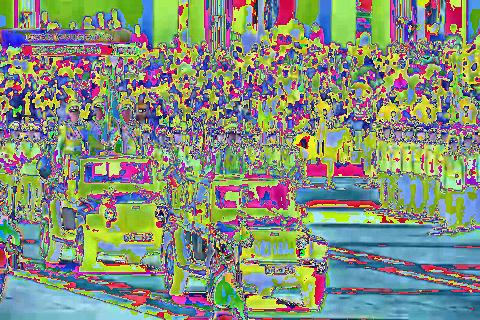

In [36]:
testimg = imgs[1]
transforms.ToPILImage()(testimg) # show tensor BACK to img

## Image Classification Models

#### Baseline: LeNet-5 from scratch

In [37]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 *  77 * 117, 120)  # 4*4 from image dimension,  77, 109 for 320 450
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window        
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)

        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) 
        return x

# LeNet5()


#### Improved: LeNet-5 With BN

In [38]:

class LeNet5_Improved(nn.Module):

    def __init__(self):
        super(LeNet5_Improved, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 *  77 * 117, 120)  # 4*4 from image dimension -> 77, 109 for 320 450
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        # extra BN layers
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(self.bn1(F.relu(self.conv1(x))), kernel_size=(2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(self.bn2(F.relu(self.conv2(x))), kernel_size=2)

        # print(x.shape)
        # x = self.aap(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # 计算log(softmax(x))
        return x

# LeNet5_Improved()

## Train

In [39]:

def train(model, train_loader, optimizer, criterion):
    model.train()
    print('===== Training =====')
    running_loss=0
    counter=0 # batch no
    running_correct = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        # calculate the loss
        loss = criterion(outputs, y_train)
        running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == y_train).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
        
        # loss and accuracy for the complete epoch
        epoch_loss = running_loss / counter
        
        # acc: correct / trained
        batch_size = X_train.shape[0]
        no_trained_examples = ((i+1)*batch_size)
        epoch_acc = 100. * (running_correct / no_trained_examples)
        
        # output batch信息
        batch_size = X_train.shape[0]
        show_bt_loss_freq = len(train_df)//batch_size//3
        if (i + 1) % show_bt_loss_freq == 0:
            print(f"{i+1} batches: {i+1}-batch-avg loss {epoch_loss:.6f}, train acc: {epoch_acc:.2f}%")
    
    
    # assert len(train_loader.dataset) == 3954
    # assert len(train_loader) == counter, f"{len(train_loader)}, {counter}" # check no_step
    epoch_loss = running_loss / len(train_loader) # avg loss on each batch
    epoch_acc = 100. * (running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

# val/test a Epoch
def validate(model, test_loader, criterion):
    model.eval() # close BN and dropout layer
    print('===== Validation =====')
    running_loss = 0.0
    running_correct = 0
    
    counter = 0 # batch 
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            X_test, y_test = data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # forward pass
            outputs = model(X_test)
            # calculate the loss
            loss = criterion(outputs, y_test)
            running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == y_test).sum().item()
        
    # loss and accuracy for the complete epoch
    # print('val', running_loss, len(test_loader.dataset))
    assert len(test_loader) == counter, f"{len(test_loader)}, {counter}" # check no_step
    epoch_loss = running_loss / len(test_loader) 
    epoch_acc = 100. * (running_correct / len(test_loader.dataset))
    return epoch_loss, epoch_acc

### Initalize Model & Hyper params


In [40]:
if use_improved_model:
    net=LeNet5_Improved()
else:
    net=LeNet5()
# net = MLP()
# net = ResNet18()


print(net)

# send to gpu
net = net.to(device)
mean = torch.FloatTensor(mean)
mean = mean.to(device)
std = torch.FloatTensor(std)
std = std.to(device)

LeNet5_Improved(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=144144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [41]:

criterion = nn.CrossEntropyLoss()


# optimizer = torch.optim.Adam(net.parameters(), lr=my_lr, weight_decay=5e-5)

if use_improved_model:
    # tuned hyperparameters - don't change
    my_lr = 2e-4
    epochs = 12
    optimizer=torch.optim.SGD(net.parameters(), lr=my_lr, momentum=0.9, weight_decay=5e-5)
    model_name = net.__class__.__name__
    opti_name = optimizer.__class__.__name__ 
    save_path = model_name + "_" + str(resize_H) + "," + str(resized_W) + "_" + opti_name + "_ep" + str(epochs) + "_lr" + str(my_lr)
else:
    # tuned hyperparameters - don't change
    my_lr = 5e-3
    epochs = 10
    optimizer=torch.optim.SGD(net.parameters(), lr=my_lr, momentum=0.9, weight_decay=5e-4)
    model_name = net.__class__.__name__
    opti_name = optimizer.__class__.__name__ 
    save_path = model_name + "_baseline_" + str(resize_H) + "," + str(resized_W) + "_" + opti_name + "_ep" + str(epochs) + "_lr" + str(my_lr)
print(f"save/read model weights:\n{save_path}")
# initialize SaveBestModel class
save_best_model = SaveBestModel(save_path=save_path)

save/read model weights:
LeNet5_Improved_320,480_SGD_ep12_lr0.0002


In [42]:

if train_mode:
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")

        train_epoch_loss, train_epoch_acc = train_mode(net, train_loader, 
                                                optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(net, test_loader, criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        
        print(f"Epoch Training loss: {train_epoch_loss:.5f}, training acc: {train_epoch_acc:.3f}%")
        print(f"Epoch Validation loss: {valid_epoch_loss:.5f}, validation acc: {valid_epoch_acc:.3f}%")
        # save the best net:
        save_best_model(
            valid_epoch_loss, epoch, net, optimizer, criterion
        )
        print('-'*50)
        
    print(f'The best minimal val loss is {save_best_model.best_valid_loss}')

    # save the trained net weights for a final time - need to submit this with the poster
    save_model(epochs, net, optimizer, criterion, save_path=save_path)
    save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name=model_name, optimizer=opti_name, save_path=save_path)
    print('TRAINING COMPLETE')
        

## Test: Prediction / Evaluation 

Evaluation by using:
1. accurancy, precision and recall (PR curve)
2. confusion matrix (visualised)

In [43]:
# load the best model checkpoint
best_model_cp = torch.load(f'{save_path}/best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs")

# load the last model checkpoint
last_model_cp = torch.load(f'{save_path}/final_model.pth')
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs")

Best model was saved at 10 epochs
Last model was saved at 12 epochs


In [44]:
def test(model, test_loader):
    model.eval()
    print('===== Testing =====')
    valid_running_correct = 0
    counter = 0 # batch no
    nb_classes = 3
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            X_test, y_test = data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # forward pass
            outputs = model(X_test)
            
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y_test).sum().item()
            # 记录下 y_true和y
            y_pred += list(np.array(preds))
            y_true += list(np.array(y_test))
            
            # get true and predict:
            for t, p in zip(y_test.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        
    # loss and accuracy for the complete epoch
    final_acc = 100. * (valid_running_correct / len(test_loader.dataset))
    return final_acc, confusion_matrix, y_pred, y_true


def round_np_float(scalar, digit: int):
    return np.around(scalar, digit)

# confusion matrix，precision，recall

def draw_PRF1_table(precision,recall,fscore, weighted_PRF1, title='Bestmodel'):
    class0_p, class0_r, class0_f1= precision[0], precision[1], precision[2]
    print(f"Class Normal: Precision: {class0_p*100:.3f}%, Recall: {class0_r*100:.3f}%, F1score:{class0_f1*100:.3f}%")
    class1_p, class1_r, class1_f1 = recall[0], recall[1], recall[2]
    print(f"Class Carrying: Precision: {class1_p*100:.3f}%, Recall: {class1_r*100:.3f}%, F1score:{class1_f1*100:.3f}%")
    class2_p, class2_r, class2_f1 = fscore[0], fscore[1], fscore[2]
    print(f"Class Threat: Precision: {class2_p*100:.3f}%, Recall: {class2_r*100:.3f}%, F1score:{class2_f1*100:.3f}%")
    wt_p, wt_r, wt_f1 = weighted_PRF1[0], weighted_PRF1[1], weighted_PRF1[2] 
    print(f"Weighted: Precision: {wt_p*100:.3f}%, Recall: {wt_r*100:.3f}%, F1score:{wt_f1*100:.3f}%")
    
    # round to precision float: 4digits
    precision = round_np_float(precision, 4)
    recall = round_np_float(recall, 4)
    fscore = round_np_float(fscore, 4)
    weighted_PRF1 = round_np_float(weighted_PRF1, 4)
    plt.figure(figsize=(6,4))
    #列名
    col= ["Precision", "Recall", "F1 score"]
    #行名: 
    row= [k + ":" + str(v) for k, v in class2label.items()] + ['Overall Weighted']

    vals = np.vstack((precision, recall, fscore, weighted_PRF1))
    plt.figure(figsize=(7,5))
    tab = plt.table(cellText=vals, 
                colLabels=col, 
                rowLabels=row,
                loc='center', 
                cellLoc='center',
                rowLoc='center')
    tab.scale(1,6) 
    plt.axis('off')
    print(f"save as {save_path}/{title}_PRF1score.png")
    plt.savefig(f'{save_path}/{title}_PRF1score.png')

In [45]:
# test two ckpts

def test_last_model(model, checkpoint, test_loader):
    print('Loading last epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc, confusion_matrix, y_pred, y_true = test(model, test_loader)
    print(f"Last epoch saved model accuracy: {test_acc:.3f}")
    creat_viz_cm(confusion_matrix, label2class, title='Finalmodel_Lenet5', save_path=save_path)
    
    # precesion recall f1score for EACH class
    precision,recall,fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=class_int)
    # and overall "weighted" precesion recall f1score
    weighted_PRF1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')[:3]
    
    # draw table
    draw_PRF1_table(precision,recall,fscore, weighted_PRF1, title='Finalmodel_Lenet5')
    return confusion_matrix, weighted_PRF1

# test the best epoch saved model
def test_best_model(model, checkpoint, test_loader):
    print('Loading best epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc, confusion_matrix, y_pred, y_true = test(model, test_loader)
    print(f"Best epoch saved model accuracy: {test_acc:.3f}")
    creat_viz_cm(confusion_matrix, label2class, title='Bestmodel_Lenet5', save_path=save_path)
    #  precesion recall f1score for EACH class
    precision,recall,fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=class_int)
    weighted_PRF1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')[:3]
    
    # draw table
    draw_PRF1_table(precision, recall, fscore, weighted_PRF1, title='Bestmodel_Lenet5')
    return confusion_matrix, weighted_PRF1
    

Loading last epoch saved model weights...
===== Testing =====


100%|██████████| 16/16 [00:56<00:00,  3.51s/it]


Last epoch saved model accuracy: 73.306
save as LeNet5_Improved_320,480_SGD_ep12_lr0.0002/Finalmodel_Lenet5_confmat.png
Class Normal: Precision: 74.737%, Recall: 69.688%, F1score:75.433%
Class Carrying: Precision: 76.344%, Recall: 72.638%, F1score:70.323%
Class Threat: Precision: 75.532%, Recall: 71.132%, F1score:72.788%
Weighted: Precision: 73.388%, Recall: 73.306%, F1score:73.306%
save as LeNet5_Improved_320,480_SGD_ep12_lr0.0002/Finalmodel_Lenet5_PRF1score.png

Loading best epoch saved model weights...
===== Testing =====


100%|██████████| 16/16 [00:54<00:00,  3.43s/it]


Best epoch saved model accuracy: 72.801
save as LeNet5_Improved_320,480_SGD_ep12_lr0.0002/Bestmodel_Lenet5_confmat.png
Class Normal: Precision: 75.477%, Recall: 68.712%, F1score:73.986%
Class Carrying: Precision: 74.462%, Recall: 72.964%, F1score:70.645%
Class Threat: Precision: 74.966%, Recall: 70.774%, F1score:72.277%
Weighted: Precision: 72.910%, Recall: 72.801%, F1score:72.822%
save as LeNet5_Improved_320,480_SGD_ep12_lr0.0002/Bestmodel_Lenet5_PRF1score.png


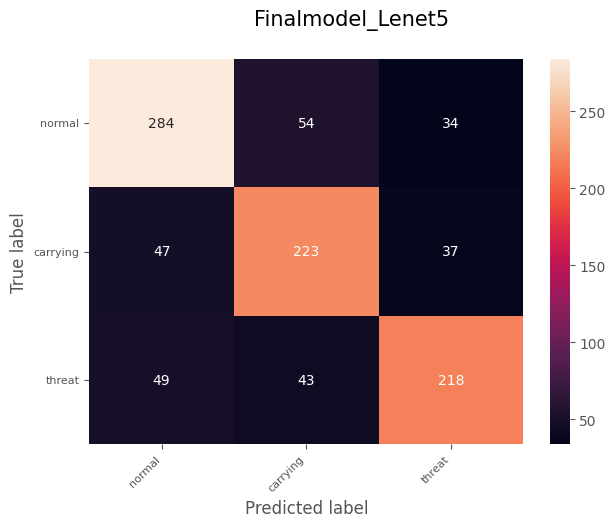

<Figure size 600x400 with 0 Axes>

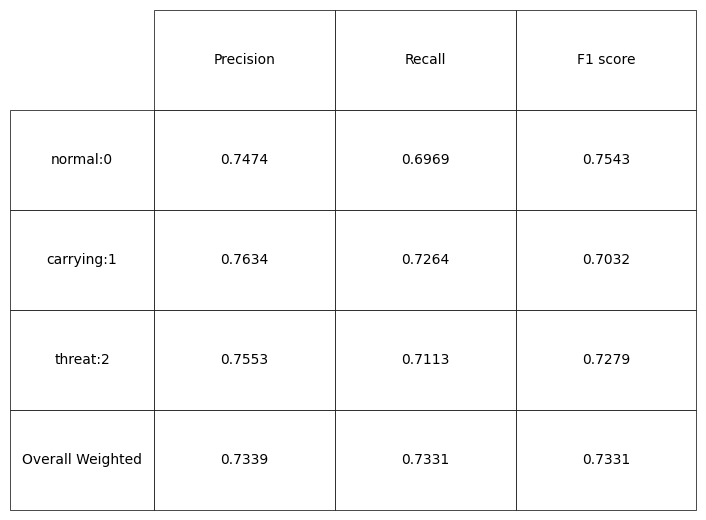

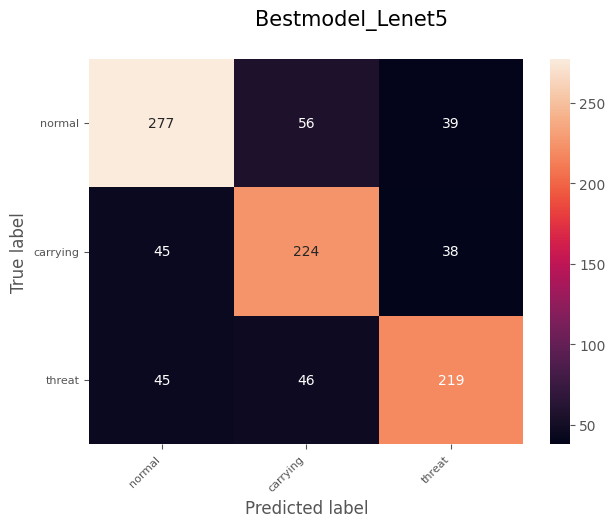

<Figure size 600x400 with 0 Axes>

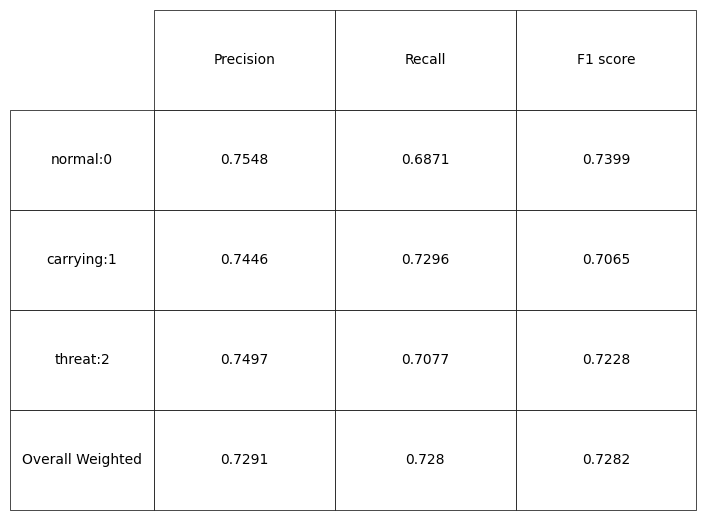

In [46]:
# run test

test_best_model(net, best_model_cp, test_loader);


In [ ]:
test_last_model(net, last_model_cp, test_loader);